In [1]:
#%% Imports
# The usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regular expressions
import re

# LightGBM
import lightgbm as lgb

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

In [2]:
#%% Import data
# Import both data sets
# trainRaw = pd.read_csv('input/train.csv')
# testRaw = pd.read_csv('input/test.csv')
trainRaw = pd.read_csv('input/train.csv')
testRaw = pd.read_csv('input/test.csv')

# And concatonate together
nTrain = trainRaw.shape[0]
full = pd.concat([trainRaw, testRaw],
                 axis=0)
full

/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [3]:
# %% Cabins

def ADSplit(s):
    """
    Function to try and extract cabin letter and number from the cabin column.
    Runs a regular expression that finds letters and numbers in the
    string. These are held in match.group, if they exist.
    """

    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)

    try:
        letter = match.group(1)
    except:
        letter = ''

    try:
        number = match.group(2)
    except:
        number = 9999

    return letter, number

In [4]:
def DR(s):
    """
    From the cabin string, try and extract letter, number, and number of cabins
    """
    # Check contents
    if isinstance(s, (int, float)):
        # If field is empty, return nothing
        letter = ''
        number = ''
        nRooms = 9999
    else:
        # If field isn't empty, split sting on space. Some strings contain
        # multiple cabins.
        s = s.split(' ')
        # Count the cabins based on number of splits
        nRooms = len(s)
        # Just take first cabin for letter/number extraction
        s = s[0]

        letter, number = ADSplit(s)

    return [letter, number, nRooms]

In [5]:
# Apply DR function to each cell in Cabin column using pandas apply method.
out = full['Cabin'].apply(DR)
# Outout tuple with 3 values for each row, convert this to pandas df
out = out.apply(pd.Series)
# And name the columns
out.columns = ['CL', 'CN', 'nC']

# Then concatenate these columns to the dataset
full = pd.concat([full, out], axis=1)
full

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CL,CN,nC
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,,,9999
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,85,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,,,9999
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,123,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,,,9999
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,,,9999
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,E,46,1
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,,,9999
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,,,9999
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,,,9999


In [6]:
# %% Family
# Add some family features directly to new columns in the dataset

# Size
full['fSize'] = full['SibSp'] + full['Parch'] + 1
# Ratio
full['fRatio'] = (full['Parch'] + 1) / (full['SibSp'] + 1)
# Adult?
full['Adult'] = full['Age'] > 18
full

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CL,CN,nC,fSize,fRatio,Adult
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,,,9999,2,0.50,True
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,85,1,2,0.50,True
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,,,9999,1,1.00,True
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,123,1,2,0.50,True
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,,,9999,1,1.00,True
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,,,9999,1,1.00,False
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,E,46,1,1,1.00,True
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,,,9999,5,0.50,False
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,,,9999,3,3.00,True
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,,,9999,2,0.50,False


In [7]:
# %% Names

# Extract titles from Name column, standardise
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}

In [8]:
def splitName(s, titleDict):
    """
    Extract title from name, replace with value in title dictionary. Also
    return surname.
    """

    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over titleDict, if s matches a key, take the
    # corresponding value as the title
    title = [t for k, t in titleDict.items() if str(k) in s]

    # If no matching keys in title dict, use 'Other'.
    if title == []:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]

    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title

In [9]:
# Apply functions to df and concatenate new columns as before
out = full['Name'].apply(splitName,
                         args=[titleDict])
out = out.apply(pd.Series)
out.columns = ['Surname', 'Title']

full = pd.concat([full, out],
                 axis=1)


# %% Categorical columns
# List of categorical columns to recode
catCols = ['Sex', 'Embarked', 'CL', 'CN', 'Surname', 'Title']

# Recode
for c in catCols:
    # Convert column to pd.Categotical
    full[c] = pd.Categorical(full[c])
    # Extract the cat.codes and replace the column with these
    full[c] = full[c].cat.codes
    # Convert the cat codes to categotical...
    full[c] = pd.Categorical(full[c])


# Generate a logical index of categorical columns to maybe use with LightGBM later
catCols = [i for i,v in enumerate(full.dtypes) if str(v)=='category']

#%% Age
# Replace missing age values with median.
# See ither kernels for more sophisticated ways of doing this!
full.loc[full.Age.isnull(), 'Age'] = np.median(full['Age'].loc[full.Age.notnull()])

In [10]:
full

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CL,CN,nC,fSize,fRatio,Adult,Surname,Title
0,22.0,NaN,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0,1,9999,2,0.50,True,99,4
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,3,92,1,2,0.50,True,181,5
2,26.0,NaN,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0,1,9999,1,1.00,True,328,3
3,35.0,C123,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,3,16,1,2,0.50,True,266,5
4,35.0,NaN,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0,1,9999,1,1.00,True,15,4
5,28.0,NaN,1,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,0,1,9999,1,1.00,False,536,4
6,54.0,E46,2,51.8625,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,17463,5,58,1,1,1.00,True,498,4
7,2.0,NaN,2,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,349909,0,1,9999,5,0.50,False,606,2
8,27.0,NaN,2,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,347742,0,1,9999,3,3.00,True,380,5
9,14.0,NaN,0,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,237736,0,1,9999,2,0.50,False,557,5


In [11]:
#%% Split datasets
train = full.iloc[0:nTrain,:]
test = full.iloc[nTrain::,:]

In [12]:
#%% Prepare data
def prepLGB(data,
            classCol='',
            IDCol='',
            fDrop=[]):

        # Drop class column
        if classCol != '':
            labels = data[classCol]
            fDrop = fDrop + [classCol]
        else:
            labels = []

        if IDCol != '':
            IDs = data[IDCol]
        else:
            IDs = []

        if fDrop != []:
           data = data.drop(fDrop,
                            axis=1)

        # Create LGB mats
        lData = lgb.Dataset(data, label=labels,
                            free_raw_data=False,
                            feature_name=list(data.columns),
                            categorical_feature='auto')

        return lData, labels, IDs, data


# Specify columns to drop
fDrop = ['Ticket', 'Cabin', 'Name']

# Split training data in to training and validation sets.
# Validation set is used for early stopping.
trainData, validData = train_test_split(train,
                                        test_size=0.3,
                                        stratify=train.Survived)

# Prepare the data sets
trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

testDataL, _, _ , testData = prepLGB(test,
                                 classCol='Survived',
                                 IDCol='PassengerId',
                                 fDrop=fDrop)

# Prepare data set using all the training data
allTrainDataL, allTrainLabels, _ , allTrainData = prepLGB(train,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

In [13]:
# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [19]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
model = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [17]:
# To view the default model params:
model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

In [21]:
# Create the grid
grid = GridSearchCV(model, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(allTrainData, allTrainLabels)

GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_estimators=100, n_jobs=3, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,...
             iid='deprecated', n_jobs=2,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.005], 'n_estimators': [40],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
      

In [22]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 6, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.6161626873510282


In [23]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 3, 'num_leaves': 6, 'learning_rate': 0.005, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754


/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


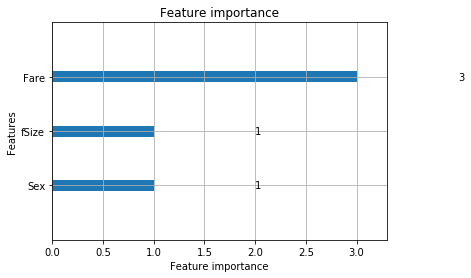

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGB

/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


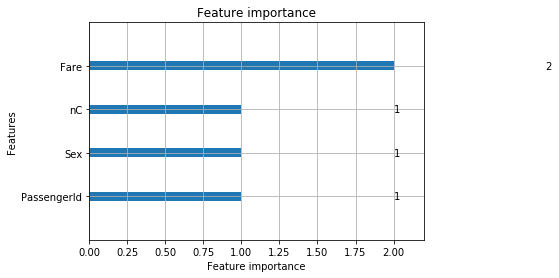

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[LightGB

/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


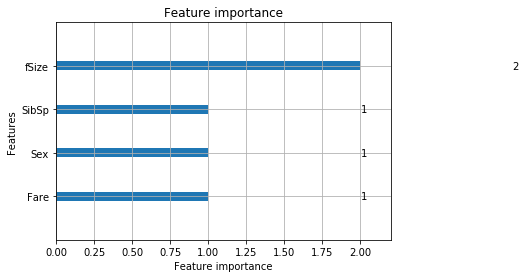

Fitting model 4
[LightGBM] [Info] Number of positive: 205, number of negative: 329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
Training until validation scores don't improve for 50 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	traini

/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/phusdt/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


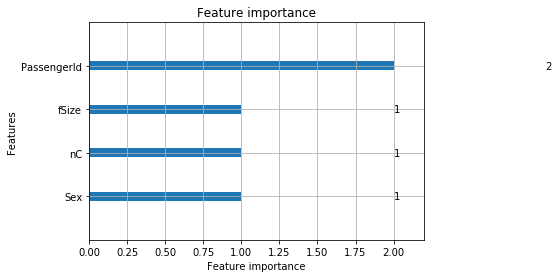

In [24]:
# Kit k models with early-stopping on different training/validation splits
k = 4
predsValid = 0
predsTrain = 0
predsTest = 0
for i in range(0, k):
    print('Fitting model', k)

    # Prepare the data set for fold
    trainData, validData = train_test_split(train,
                                            test_size=0.4,
                                            stratify=train.Survived)
    trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    # Train
    gbm = lgb.train(params,
                    trainDataL,
                    100000,
                    valid_sets=[trainDataL, validDataL],
                    early_stopping_rounds=50,
                    verbose_eval=4)

    # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

    # Predict
    predsValid += gbm.predict(validData,
                              num_iteration=gbm.best_iteration)/k
    predsTrain += gbm.predict(trainData,
                              num_iteration=gbm.best_iteration)/k
    predsTest += gbm.predict(testData,
                             num_iteration=gbm.best_iteration)/k

In [31]:
# Print assessment
# assessMod(predsTrain, trainLabels, predsValid=predsValid, yValid= validLabels,
#           report=True, plot=True)

# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest > 0.5)
#sub.to_csv('sub2.csv', index=False)
sub.Survived == 1)

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
388    False
389    False
390    False
391    False
392    False
393    False
394    False
395    False
396    False
397    False
398    False
399    False
400    False
401    False
402    False
403    False
404    False
405    False
406    False
407    False
408    False
409    False
410    False
411    False
412    False
413    False
414    False
415    False
416    False
417    False
Name: Survived, Length: 418, dtype: bool